In [1]:
import torch
import openvino as ov
import openvino.properties.hint as hints
import openvino.properties as props
import numpy as np
from time import perf_counter
import matplotlib.pyplot as plt
from seis_proc_dl.detectors.models.unet_model import UNetModel


In [2]:
# Load the torch model
model_to_load = "/uufs/chpc.utah.edu/common/home/koper-group3/alysha/selected_models/pDetectorMew_model_026.pt"
torchmodel = UNetModel(apply_last_sigmoid=True, num_channels=3, num_classes=1).to('cpu')      
check_point = torch.load(model_to_load, map_location='cpu')
torchmodel.load_state_dict(check_point['model_state_dict']);
torchmodel.eval();

In [3]:
n_threads="4"

In [4]:
# Convert the model to openvino
ov_model = ov.convert_model(torchmodel, input=([1, 3, 1008], ov.Type.f32))#example_input=(input,))

# Compile the model for the appropriate device
core = ov.Core()

# Throughput is better for async api
ov_compiled_model_tput = core.compile_model(ov_model, 
                                        'CPU',
                                        config={ov.properties.inference_num_threads(): n_threads,
                                               # ov.properties.num_streams(): "AUTO",
                                                #hints.enable_hyper_threading(): True,
                                                hints.performance_mode: hints.PerformanceMode.THROUGHPUT, })
                                                #hints.enable_cpu_pinning: True,})
                                                #ov.properties.affinity(): "NUMA"})

# Latency is better optimization for sync API
ov_compiled_model_lat = core.compile_model(ov_model, 
                                        'CPU',
                                        config={ov.properties.inference_num_threads(): n_threads,
                                                hints.performance_mode: hints.PerformanceMode.LATENCY})


In [5]:
def print_ov_model_properties(ov_compiled_model):
    # Query and print all available properties
    properties = core.get_property("CPU", "SUPPORTED_PROPERTIES")
    print("\nAvailable Properties:")
    for prop in properties:
        try:
            value = ov_compiled_model.get_property(prop)
            print(f"{prop}: {value}")
        except Exception as e:
            pass
            #print(f"{prop}: {e}")

In [6]:
print_ov_model_properties(ov_compiled_model_tput)


Available Properties:
SUPPORTED_PROPERTIES: {'SUPPORTED_PROPERTIES': 'RO', 'NETWORK_NAME': 'RO', 'OPTIMAL_NUMBER_OF_INFER_REQUESTS': 'RO', 'NUM_STREAMS': 'RO', 'AFFINITY': 'RO', 'INFERENCE_NUM_THREADS': 'RO', 'PERF_COUNT': 'RO', 'INFERENCE_PRECISION_HINT': 'RO', 'PERFORMANCE_HINT': 'RO', 'EXECUTION_MODE_HINT': 'RO', 'PERFORMANCE_HINT_NUM_REQUESTS': 'RO', 'ENABLE_CPU_PINNING': 'RO', 'SCHEDULING_CORE_TYPE': 'RO', 'MODEL_DISTRIBUTION_POLICY': 'RO', 'ENABLE_HYPER_THREADING': 'RO', 'EXECUTION_DEVICES': 'RO', 'CPU_DENORMALS_OPTIMIZATION': 'RO', 'LOG_LEVEL': 'RO', 'CPU_SPARSE_WEIGHTS_DECOMPRESSION_RATE': 'RO', 'DYNAMIC_QUANTIZATION_GROUP_SIZE': 'RO', 'KV_CACHE_PRECISION': 'RO'}
EXECUTION_DEVICES: ['CPU']
NUM_STREAMS: 4
AFFINITY: Affinity.CORE
INFERENCE_NUM_THREADS: 4
PERF_COUNT: NO
INFERENCE_PRECISION_HINT: <Type: 'float32'>
PERFORMANCE_HINT: THROUGHPUT
EXECUTION_MODE_HINT: ExecutionMode.PERFORMANCE
PERFORMANCE_HINT_NUM_REQUESTS: 0
ENABLE_CPU_PINNING: True
SCHEDULING_CORE_TYPE: SchedulingCor

In [7]:
print_ov_model_properties(ov_compiled_model_lat)


Available Properties:
SUPPORTED_PROPERTIES: {'SUPPORTED_PROPERTIES': 'RO', 'NETWORK_NAME': 'RO', 'OPTIMAL_NUMBER_OF_INFER_REQUESTS': 'RO', 'NUM_STREAMS': 'RO', 'AFFINITY': 'RO', 'INFERENCE_NUM_THREADS': 'RO', 'PERF_COUNT': 'RO', 'INFERENCE_PRECISION_HINT': 'RO', 'PERFORMANCE_HINT': 'RO', 'EXECUTION_MODE_HINT': 'RO', 'PERFORMANCE_HINT_NUM_REQUESTS': 'RO', 'ENABLE_CPU_PINNING': 'RO', 'SCHEDULING_CORE_TYPE': 'RO', 'MODEL_DISTRIBUTION_POLICY': 'RO', 'ENABLE_HYPER_THREADING': 'RO', 'EXECUTION_DEVICES': 'RO', 'CPU_DENORMALS_OPTIMIZATION': 'RO', 'LOG_LEVEL': 'RO', 'CPU_SPARSE_WEIGHTS_DECOMPRESSION_RATE': 'RO', 'DYNAMIC_QUANTIZATION_GROUP_SIZE': 'RO', 'KV_CACHE_PRECISION': 'RO'}
EXECUTION_DEVICES: ['CPU']
NUM_STREAMS: 1
AFFINITY: Affinity.CORE
INFERENCE_NUM_THREADS: 4
PERF_COUNT: NO
INFERENCE_PRECISION_HINT: <Type: 'float32'>
PERFORMANCE_HINT: LATENCY
EXECUTION_MODE_HINT: ExecutionMode.PERFORMANCE
PERFORMANCE_HINT_NUM_REQUESTS: 0
ENABLE_CPU_PINNING: True
SCHEDULING_CORE_TYPE: SchedulingCoreTy

In [8]:
def do_async(compiled_model, N_ex=1000, bs=1, process="none", shared_memory=True, return_stats=False):
    """I think this will work for model with preprocessing or without. Just swap data_shape1 and data_shape2.

    Args:
        compiled_model (_type_): _description_
        N_ex (int, optional): _description_. Defaults to 1000.
        bs (int, optional): _description_. Defaults to 1.
        data_shape1 (int, optional): _description_. Defaults to 1008.
        data_shape2 (int, optional): _description_. Defaults to 3.
    """
    W = 1008
    C = 3

    data_shape1 = C
    data_shape2 = W

    if process not in ["none", "manual", "api"]:
        raise ValueError("preprocess must be none, manual, or api")

    # If doing any preprocessing, start with not transposed array and expect
    # squeezed output
    if process != "none":
        data_shape1 = W
        data_shape2 = C

    # Make input data 
    if N_ex % bs != 0:
        N_ex = N_ex + (bs - N_ex%bs)

    rng = np.random.default_rng(seed=0)    
    data = rng.random((N_ex, data_shape1, data_shape2))
    
    output_array_async = np.zeros((N_ex, 1, 1008), dtype=np.float32)
    if process == "api":
        output_array_async = np.zeros((N_ex, 1008), dtype=np.uint8)
        
    # If not doing any processing, convert to f32. Otherwise, convert to f64 so preprocessing 
    # is required.  
    if process == "none":
        data = data.astype(np.float32)
    else:
        data = data.astype(np.float64)
    print("Original data shape:", data.shape)

    # Set up inference request
    num_requests = compiled_model.get_property(props.optimal_number_of_infer_requests)
    print("Optimal number of requests: ", num_requests)
    infer_queue = ov.AsyncInferQueue(compiled_model, num_requests)

    # Function for storing the results
    def callback(infer_request, userdata):
        results = infer_request.get_output_tensor().data
        s = results.shape[0]
        output_array_async[userdata:userdata+s] = results
    infer_queue.set_callback(callback)

    start = perf_counter()

    # Do the preprocessing explicitly
    if process == "manual":
        # Have to add copy or get error about contiguous memory
        data = data.transpose((0, 2, 1)).astype("float32").copy()

    # Moving shared_tensor to here isn't any faster, but it might make 
    # it slower if using shared_memory = False
    # shared_tensor = ov.Tensor(data, shared_memory=shared_memory)
    sind = 0
    while sind < N_ex:
        eind = np.min([N_ex, sind+bs*num_requests])

        for i in range(sind, eind, bs):
            shared_tensor = ov.Tensor(data[i:i+bs, :, :], shared_memory=shared_memory)
            infer_queue.start_async({0: shared_tensor}, userdata=i)
            # infer_queue.start_async({0: shared_tensor.data[i:i+bs, :, :]}, userdata=i)

        sind += num_requests*bs
    infer_queue.wait_all()

    if process == "manual":
        output_array_async = (np.squeeze(output_array_async, axis=1)*100).astype(np.uint8)
    
    end = perf_counter()
    
    time_ir = end-start
    print(f"Total time: {time_ir:0.5f} s")
    print(f"seconds per example: {time_ir/N_ex:0.5f} s")
    print("FPS:", N_ex/time_ir)
    print("Output data shape:", output_array_async.shape)

    if return_stats:
        stats = {"total_time": time_ir,
                 "N": N_ex}
        return output_array_async, stats

    return output_array_async

In [9]:
output_async_none_shared = do_async(ov_compiled_model_tput)
print(type(output_async_none_shared[0][0][0]), np.max(output_async_none_shared))

Original data shape: (1000, 3, 1008)
Optimal number of requests:  4
Total time: 7.06194 s
seconds per example: 0.00706 s
FPS: 141.60422209872914
Output data shape: (1000, 1, 1008)
<class 'numpy.float32'> 0.00017242598


In [10]:
output_async_none = do_async(ov_compiled_model_tput, shared_memory=False)
print(type(output_async_none[0][0][0]), np.max(output_async_none))

Original data shape: (1000, 3, 1008)
Optimal number of requests:  4
Total time: 7.11574 s
seconds per example: 0.00712 s
FPS: 140.53349031566168
Output data shape: (1000, 1, 1008)
<class 'numpy.float32'> 0.00017242598


In [11]:
output_async_manual_shared = do_async(ov_compiled_model_tput, process="manual")
print(type(output_async_manual_shared[0][0]), np.max(output_async_manual_shared))

Original data shape: (1000, 1008, 3)
Optimal number of requests:  4
Total time: 7.09367 s
seconds per example: 0.00709 s
FPS: 140.97070853903543
Output data shape: (1000, 1008)
<class 'numpy.uint8'> 0


In [12]:
output_async_manual = do_async(ov_compiled_model_tput, process="manual", shared_memory=False)
print(type(output_async_manual[0][0]), np.max(output_async_manual))

Original data shape: (1000, 1008, 3)
Optimal number of requests:  4
Total time: 7.08923 s
seconds per example: 0.00709 s
FPS: 141.05898739680353
Output data shape: (1000, 1008)
<class 'numpy.uint8'> 0


In [13]:
def do_sync(compiled_model, N_ex=1000, bs=1, process="none", shared_memory=True, return_stats=False):
    W = 1008
    C = 3

    data_shape1 = C
    data_shape2 = W

    if process not in ["none", "manual", "api"]:
        raise ValueError("preprocess must be none, manual, or api")

    # If doing any preprocessing, start with not transposed array and expect
    # squeezed output
    if process != "none":
        data_shape1 = W
        data_shape2 = C

    # Make input data 
    if N_ex % bs != 0:
        N_ex = N_ex + (bs - N_ex%bs)

    rng = np.random.default_rng(seed=0)    
    data = rng.random((N_ex, data_shape1, data_shape2))
    
    output_array_sync = np.zeros((N_ex, 1, 1008), dtype=np.float32)
    if process == "api":
        output_array_sync = np.zeros((N_ex, 1008), dtype=np.uint8)
        
    # If not doing any processing, convert to f32. Otherwise, convert to f64 so preprocessing 
    # is required.  
    if process == "none":
        data = data.astype(np.float32)
    else:
        data = data.astype(np.float64)
    print("Original data shape:", data.shape)

    start = perf_counter()

    # Do the preprocessing explicitly
    if process == "manual":
        # Have to add copy or get error about contiguous memory
        data = data.transpose((0, 2, 1)).astype("float32").copy()
    
    # Moving shared_tensor to here isn't any faster 
    # shared_tensor = ov.Tensor(data, shared_memory=shared_memory)
        
    for i in range(0, N_ex, bs):
        shared_tensor = ov.Tensor(data[i:i+bs, :, :], shared_memory=shared_memory)
        output_array_sync[i:i+bs, :] = compiled_model({0:shared_tensor})[0]
        # output_array_sync[i, :] = compiled_model({0:shared_tensor.data[i:i+bs, :, :]})[0]
        
    # Do the postprocessing explicitly
    if process == "manual":
        output_array_sync = (np.squeeze(output_array_sync, axis=1)*100).astype(np.uint8)

    end = perf_counter()
    time_ir = end-start
    print(time_ir)
    print((time_ir)/N_ex, "s per ex")
    print("FPS:", N_ex/time_ir)
    print(output_array_sync.shape)

    if return_stats:
        stats = {"total_time": time_ir,
                 "N": N_ex}
        return output_array_sync, stats
    
    return output_array_sync

In [14]:
output_sync_none_shared = do_sync(ov_compiled_model_lat)
print(type(output_sync_none_shared[0][0][0]), np.max(output_sync_none_shared))

Original data shape: (1000, 3, 1008)
8.159033704549074
0.008159033704549075 s per ex
FPS: 122.56353340499739
(1000, 1, 1008)
<class 'numpy.float32'> 0.00017242598


In [15]:
# THROUGHPUT optimized model is much slower with sync API
output_sync_none_shared_tput = do_sync(ov_compiled_model_tput)
print(type(output_sync_none_shared_tput[0][0][0]), np.max(output_sync_none_shared_tput))

Original data shape: (1000, 3, 1008)
28.669974975287914
0.028669974975287914 s per ex
FPS: 34.87969560008162
(1000, 1, 1008)
<class 'numpy.float32'> 0.00017242598


In [16]:
output_sync_none = do_sync(ov_compiled_model_lat, shared_memory=False)
print(type(output_sync_none[0][0][0]), np.max(output_sync_none))

Original data shape: (1000, 3, 1008)
7.952094752341509
0.007952094752341508 s per ex
FPS: 125.75302874824878
(1000, 1, 1008)
<class 'numpy.float32'> 0.00017242598


In [17]:
output_sync_manual_shared = do_sync(ov_compiled_model_lat, process="manual")
print(type(output_sync_manual_shared[0][0]), np.max(output_sync_manual_shared))

Original data shape: (1000, 1008, 3)
7.917240019887686
0.007917240019887686 s per ex
FPS: 126.30664189642516
(1000, 1008)
<class 'numpy.uint8'> 0


In [18]:
output_sync_manual = do_sync(ov_compiled_model_lat, process="manual", shared_memory=False)
print(type(output_sync_manual[0][0]), np.max(output_sync_manual))

Original data shape: (1000, 1008, 3)
7.922588884830475
0.007922588884830474 s per ex
FPS: 126.22136709816134
(1000, 1008)
<class 'numpy.uint8'> 0


In [19]:
assert np.allclose(output_async_none, output_sync_none)

# Preprocessing

In [20]:
from openvino.preprocess import PrePostProcessor
from openvino import Layout, Type
import openvino.runtime.opset12 as ops
from openvino.runtime import Output
from openvino.runtime.utils.decorators import custom_preprocess_function

In [21]:
bs = 1

def build_prepostprocessor(org_model, bs):
    ppp = PrePostProcessor(org_model)

    # Declare User’s Data Format
    # The input tensor is originally float64 and in shape NWC (N, 1008, 3)
    ppp.input().tensor() \
            .set_element_type(Type.f64) \
            .set_shape([bs, 1008, 3]) \
            .set_layout(Layout('NWC'))

    # Declaring Model Layout
    # The model expects shape (N, 3, 1008)
    ppp.input().model().set_layout(Layout('NCW'))

    # Preprocessing steps
    # Convert the input to float 32 and transpose
    ppp.input().preprocess() \
        .convert_element_type(Type.f32) \
        .convert_layout(Layout("NCW")) 

    @custom_preprocess_function
    def custom_multiply_by_100(output: Output):
        # Custom nodes can be inserted as Post-processing steps
        return ops.multiply(output, np.float32(100))

    @custom_preprocess_function
    def custom_squeeze(output: Output):
        # Custom nodes can be inserted as Post-processing steps
        return ops.squeeze(output, axes=[1])

    # Expect the output to be shape Nx1008 (no channels)
    ppp.output().tensor()\
        .set_layout(Layout("NW"))

    # Perform squeeze to remove C axis, 
    # multiply by 100 so values are between 0 and 100, 
    # convert to unsigned int 8
    ppp.output().postprocess()\
        .custom(custom_squeeze)\
        .custom(custom_multiply_by_100)\
        .convert_element_type(Type.u8)

    # Integrating Steps into a Model
    ppp_model = ppp.build()

    return ppp_model

ppp_model = build_prepostprocessor(ov_model, bs)

compiled_model_lat_with_preprocess_api = core.compile_model(model=ppp_model, 
                                                        device_name="CPU",
                                                        config={ov.properties.inference_num_threads(): n_threads,
                                                        hints.performance_mode: hints.PerformanceMode.LATENCY,})

compiled_model_tp_with_preprocess_api = core.compile_model(model=ppp_model, 
                                                        device_name="CPU",
                                                        config={ov.properties.inference_num_threads(): n_threads,
                                                                hints.performance_mode: hints.PerformanceMode.THROUGHPUT,})

In [22]:
output_aysnc_api_shared = do_async(compiled_model_tp_with_preprocess_api, process="api")
print(type(output_aysnc_api_shared[0][0]), np.max(output_aysnc_api_shared))

Original data shape: (1000, 1008, 3)
Optimal number of requests:  4
Total time: 7.05566 s
seconds per example: 0.00706 s
FPS: 141.73024561202394
Output data shape: (1000, 1008)
<class 'numpy.uint8'> 0


In [23]:
output_aysnc_api = do_async(compiled_model_tp_with_preprocess_api, process="api", shared_memory=False)
print(type(output_aysnc_api[0][0]), np.max(output_aysnc_api))

Original data shape: (1000, 1008, 3)
Optimal number of requests:  4
Total time: 7.03112 s
seconds per example: 0.00703 s
FPS: 142.22483133463592
Output data shape: (1000, 1008)
<class 'numpy.uint8'> 0


In [24]:
output_sync_api_shared = do_sync(compiled_model_lat_with_preprocess_api, process="api")
print(type(output_sync_api_shared[0][0]), np.max(output_sync_api_shared))

Original data shape: (1000, 1008, 3)
8.054630625993013
0.008054630625993013 s per ex
FPS: 124.1521860447468
(1000, 1008)
<class 'numpy.uint8'> 0


In [25]:
output_sync_api = do_sync(compiled_model_lat_with_preprocess_api, process="api", shared_memory=False)
print(type(output_sync_api[0][0]), np.max(output_sync_api))

Original data shape: (1000, 1008, 3)
7.957416068762541
0.007957416068762541 s per ex
FPS: 125.66893465902558
(1000, 1008)
<class 'numpy.uint8'> 0


# Try different batch size

In [26]:
def grid_search_bs_threads(bs_list, nthreads_list, use_async=True, process="none", N_ex=1000, N_iters=1):
    results = {}

    inference_func = do_sync
    perf_hint = hints.PerformanceMode.LATENCY
    if use_async:
        inference_func = do_async
        perf_hint = hints.PerformanceMode.THROUGHPUT

    for n_threads in nthreads_list:
        bs_results = {}
        for bs in bs_list:
            print(f"USING NTHREADS={n_threads}, BATCHSIZE={bs}")
            
            # Convert the model to openvino
            ov_model_bs = ov.convert_model(torchmodel, input=[bs, 3, 1008])

            if process == "api":
                ov_model_bs = build_prepostprocessor(ov_model_bs, bs)

            compiled_model = core.compile_model(model=ov_model_bs, 
                                                device_name="CPU",
                                                config={ov.properties.inference_num_threads(): n_threads,
                                                        hints.performance_mode: perf_hint,})
                                                        #ov.properties.affinity(): "NUMA"})
            iter_results = []
            bs_iter_results = {}
            for iter in range(N_iters):
                outputs, stats = inference_func(compiled_model, 
                                            N_ex=N_ex, 
                                            bs=bs, 
                                            process=process, 
                                            shared_memory=True, 
                                            return_stats=True)
                iter_results.append(stats)

            if N_iters > 1:
                bs_iter_results["iters_times"] = [entry["total_time"] for entry in iter_results]
                bs_iter_results["avg_time"] = np.sum(bs_iter_results["iters_times"])/N_iters
                bs_iter_results["N"] = iter_results[0]["N"]
                bs_iter_results["N_iters"] = N_iters
                bs_results[f"{bs}"] = bs_iter_results
            elif N_iters == 1:
                bs_results[f"{bs}"] = stats
                
        results[f"{n_threads}"] = bs_results

    return results

In [29]:
bs_list = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
nthreads_list = [1, 2, 4, 8]
async_results = grid_search_bs_threads(bs_list, nthreads_list, use_async=True, process="manual", N_ex=8192, N_iters=5)

USING NTHREADS=1, BATCHSIZE=1
Original data shape: (8192, 1008, 3)
Optimal number of requests:  1
Total time: 231.10518 s
seconds per example: 0.02821 s
FPS: 35.447064241747846
Output data shape: (8192, 1008)
Original data shape: (8192, 1008, 3)
Optimal number of requests:  1
Total time: 232.25630 s
seconds per example: 0.02835 s
FPS: 35.27137942545279
Output data shape: (8192, 1008)
Original data shape: (8192, 1008, 3)
Optimal number of requests:  1
Total time: 231.04768 s
seconds per example: 0.02820 s
FPS: 35.4558858841374
Output data shape: (8192, 1008)
Original data shape: (8192, 1008, 3)
Optimal number of requests:  1
Total time: 230.64131 s
seconds per example: 0.02815 s
FPS: 35.51835462521058
Output data shape: (8192, 1008)
Original data shape: (8192, 1008, 3)
Optimal number of requests:  1
Total time: 232.16088 s
seconds per example: 0.02834 s
FPS: 35.28587538489423
Output data shape: (8192, 1008)
USING NTHREADS=1, BATCHSIZE=2
Original data shape: (8192, 1008, 3)
Optimal numbe

threads=1, bs=1 FPS=35.40, NORM_FPS=35.40
threads=1, bs=2 FPS=35.21, NORM_FPS=35.21
threads=1, bs=4 FPS=36.14, NORM_FPS=36.14
threads=1, bs=8 FPS=36.85, NORM_FPS=36.85
threads=1, bs=16 FPS=37.38, NORM_FPS=37.38
threads=1, bs=32 FPS=37.24, NORM_FPS=37.24
threads=1, bs=64 FPS=36.79, NORM_FPS=36.79
threads=1, bs=128 FPS=36.95, NORM_FPS=36.95
threads=1, bs=256 FPS=36.57, NORM_FPS=36.57
threads=1, bs=512 FPS=37.00, NORM_FPS=37.00
threads=2, bs=1 FPS=70.80, NORM_FPS=35.40
threads=2, bs=2 FPS=71.97, NORM_FPS=35.98
threads=2, bs=4 FPS=73.95, NORM_FPS=36.98
threads=2, bs=8 FPS=74.73, NORM_FPS=37.36
threads=2, bs=16 FPS=73.49, NORM_FPS=36.74
threads=2, bs=32 FPS=73.42, NORM_FPS=36.71
threads=2, bs=64 FPS=72.97, NORM_FPS=36.49
threads=2, bs=128 FPS=73.09, NORM_FPS=36.55
threads=2, bs=256 FPS=73.54, NORM_FPS=36.77
threads=2, bs=512 FPS=72.81, NORM_FPS=36.40
threads=4, bs=1 FPS=141.45, NORM_FPS=35.36
threads=4, bs=2 FPS=146.41, NORM_FPS=36.60
threads=4, bs=4 FPS=144.32, NORM_FPS=36.08
threads=4, bs

Text(0.5, 1.0, 'Async API')

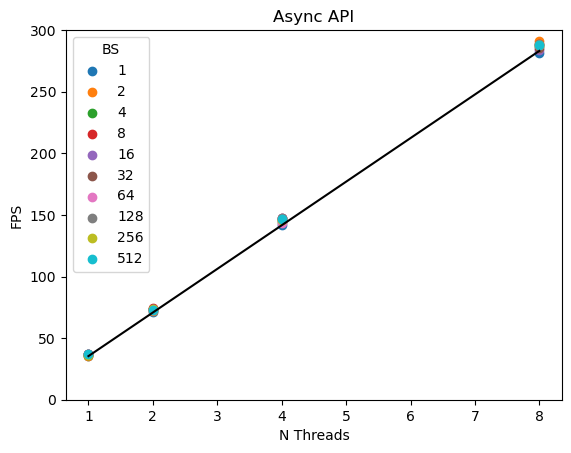

In [44]:
fig = plt.figure()
pref = ""

for nt in async_results:
    nt_results = async_results[nt]
    for bs in nt_results:
        fps = nt_results[bs]['N']/nt_results[bs]['avg_time']
        # nt = int(nt_key.split("_")[1])
        # bs = int(bs_key.split("_")[1])
        print(f"threads={nt}, bs={bs} FPS={fps:0.2f}, NORM_FPS={fps/int(nt):0.2f}")
        ind = bs_list.index(int(bs))
        plt.scatter(int(nt), fps, color=f"C{ind}", label=pref+bs)
    pref = "_"

plt.plot(nthreads_list,
         np.array(nthreads_list)*(async_results['1']['1']["N"]/async_results['1']['1']["avg_time"]),
         color="k")

plt.ylabel("FPS")
plt.xlabel("N Threads")
plt.legend(title="BS")
plt.ylim([0, 300])
plt.title("Async API")
        

In [31]:
# Number of windows in a day
npts = 24*60*60*100
window_length = 1008
sliding_interval = 500

n_windows = (npts-window_length)//sliding_interval + 1
n_windows

17278

In [32]:
bs_list = [2, 16, 128, 512, 1024]
nthreads_list = [4]
n_windows_results = grid_search_bs_threads(bs_list, nthreads_list, use_async=True, process="manual", N_ex=n_windows)

USING NTHREADS=4, BATCHSIZE=2
Original data shape: (17278, 1008, 3)
Optimal number of requests:  4
Total time: 118.29507 s
seconds per example: 0.00685 s
FPS: 146.0584907405241
Output data shape: (17278, 1008)
USING NTHREADS=4, BATCHSIZE=16
Original data shape: (17280, 1008, 3)
Optimal number of requests:  2
Total time: 118.24595 s
seconds per example: 0.00684 s
FPS: 146.13608528466995
Output data shape: (17280, 1008)
USING NTHREADS=4, BATCHSIZE=128
Original data shape: (17280, 1008, 3)
Optimal number of requests:  2
Total time: 118.98963 s
seconds per example: 0.00689 s
FPS: 145.22274034614608
Output data shape: (17280, 1008)
USING NTHREADS=4, BATCHSIZE=512
Original data shape: (17408, 1008, 3)
Optimal number of requests:  2
Total time: 119.16312 s
seconds per example: 0.00685 s
FPS: 146.08546770976685
Output data shape: (17408, 1008)
USING NTHREADS=4, BATCHSIZE=1024
Original data shape: (17408, 1008, 3)
Optimal number of requests:  2
Total time: 124.83270 s
seconds per example: 0.007

In [33]:
bs_list = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
nthreads_list = [1, 2, 4, 8]
sync_results = grid_search_bs_threads(bs_list, nthreads_list, use_async=False, process="manual", N_ex=8192, N_iters=5)

USING NTHREADS=1, BATCHSIZE=1
Original data shape: (8192, 1008, 3)
231.131444003433
0.028214287598075316 s per ex
FPS: 35.44303560825036
(8192, 1008)
Original data shape: (8192, 1008, 3)
232.04826894402504
0.02832620470508118 s per ex
FPS: 35.30299983395301
(8192, 1008)
Original data shape: (8192, 1008, 3)
233.21822760254145
0.02846902192413836 s per ex
FPS: 35.12589939565568
(8192, 1008)
Original data shape: (8192, 1008, 3)
231.79450676962733
0.028295227877151774 s per ex
FPS: 35.34164857557108
(8192, 1008)
Original data shape: (8192, 1008, 3)
231.91060531139374
0.028309400062425993 s per ex
FPS: 35.323955922586386
(8192, 1008)
USING NTHREADS=1, BATCHSIZE=2
Original data shape: (8192, 1008, 3)
241.24951492995024
0.02944940367797244 s per ex
FPS: 33.95654495876872
(8192, 1008)
Original data shape: (8192, 1008, 3)
239.19237268716097
0.029198287681538204 s per ex
FPS: 34.24858371514335
(8192, 1008)
Original data shape: (8192, 1008, 3)
232.37350383028388
0.0283659062292827 s per ex
FPS: 3

threads=1, bs=1 FPS=35.31, NORM_FPS=35.31
threads=1, bs=2 FPS=34.92, NORM_FPS=34.92
threads=1, bs=4 FPS=35.94, NORM_FPS=35.94
threads=1, bs=8 FPS=36.66, NORM_FPS=36.66
threads=1, bs=16 FPS=36.34, NORM_FPS=36.34
threads=1, bs=32 FPS=36.33, NORM_FPS=36.33
threads=1, bs=64 FPS=36.53, NORM_FPS=36.53
threads=1, bs=128 FPS=36.55, NORM_FPS=36.55
threads=1, bs=256 FPS=36.77, NORM_FPS=36.77
threads=1, bs=512 FPS=36.74, NORM_FPS=36.74
threads=2, bs=1 FPS=66.32, NORM_FPS=33.16
threads=2, bs=2 FPS=66.89, NORM_FPS=33.45
threads=2, bs=4 FPS=71.24, NORM_FPS=35.62
threads=2, bs=8 FPS=73.01, NORM_FPS=36.50
threads=2, bs=16 FPS=74.08, NORM_FPS=37.04
threads=2, bs=32 FPS=73.51, NORM_FPS=36.76
threads=2, bs=64 FPS=73.11, NORM_FPS=36.55
threads=2, bs=128 FPS=74.02, NORM_FPS=37.01
threads=2, bs=256 FPS=72.73, NORM_FPS=36.37
threads=2, bs=512 FPS=73.90, NORM_FPS=36.95
threads=4, bs=1 FPS=123.12, NORM_FPS=30.78
threads=4, bs=2 FPS=126.82, NORM_FPS=31.71
threads=4, bs=4 FPS=134.49, NORM_FPS=33.62
threads=4, bs

Text(0.5, 1.0, 'Sync API')

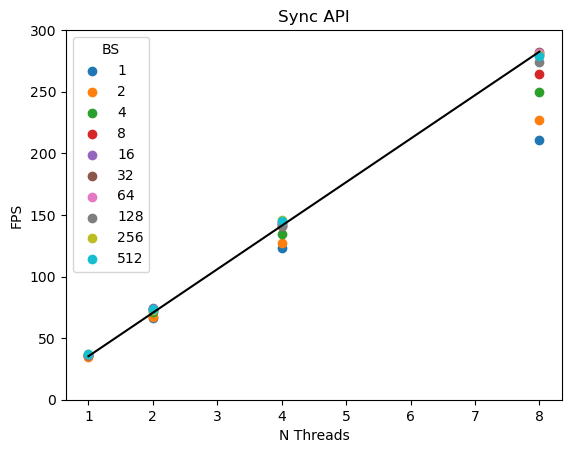

In [45]:
fig = plt.figure()
pref = ""

for nt in sync_results:
    nt_results = sync_results[nt]
    for bs in nt_results:
        fps = nt_results[bs]['N']/nt_results[bs]['avg_time']
        # nt = int(nt_key.split("_")[1])
        # bs = int(bs_key.split("_")[1])
        print(f"threads={nt}, bs={bs} FPS={fps:0.2f}, NORM_FPS={fps/int(nt):0.2f}")
        ind = bs_list.index(int(bs))
        plt.scatter(int(nt), fps, color=f"C{ind}", label=pref+bs)
    pref = "_"

plt.plot(nthreads_list,
         np.array(nthreads_list)*(sync_results['1']['1']["N"]/sync_results['1']['1']["avg_time"]),
         color="k")

plt.ylabel("FPS")
plt.xlabel("N Threads")
plt.legend(title="BS")
plt.ylim([0, 300])
plt.title("Sync API")
        

# Some stats

In [35]:
# Roughly 7 s for 1000 examples with 4 threads
n_windows*(7/1000)

120.946

In [36]:
# Time to run one day with 4 threads on slurm with sync api 
218/n_windows

0.012617201064938072

In [37]:
(7/1000)

0.007

In [38]:
n_windows*((7/1000) - 0.0126)

-96.7568

# Other small speed tests

In [39]:
data = np.random.rand(1000, 1008, 3)
new_data = np.zeros((1000, 500, 3))

start = perf_counter()
for i in range(data.shape[0]):
    new_data[i, :, :] = data[i, 256:756, :]
end = perf_counter()

print(end-start)


0.0042027682065963745


In [40]:
data = np.random.rand(1000, 1008, 3)
new_data = np.zeros((1000, 1008, 3))

start = perf_counter()
for i in range(data.shape[0]):
    new_data[i, :, :] = data[i, :, :]
new_data = new_data[:, 256:756, :]
end = perf_counter()

print(end-start)

0.00713396817445755


In [41]:
input = np.random.rand(1000, 3, 1008).astype('float32')
start = perf_counter()
for _ in range(1000):
    expansion = np.zeros((2, 3, 1008))
    input2 = np.concatenate([input, expansion], axis=0) 
end = perf_counter()
print((end-start)/1000)

0.0026769273616373537


In [42]:
input = np.random.rand(1000, 3, 1008).astype('float32')
start = perf_counter()
for _ in range(1000):
    expansion = np.zeros((2, 3, 1008))
    input2 = np.append(input, expansion, axis=0) 
end = perf_counter()
print((end-start)/1000)

0.002678870182484388


In [43]:
input = np.random.rand(1000, 3, 1008).astype('float32')
start = perf_counter()
for _ in range(1000):
    input2 = np.zeros((1002, 3, 1008))
    input2[0:1000, :, :] = input
end = perf_counter()
print((end-start)/1000)

0.006119684673845768
